# **StarGAN - CelebA**

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import itertools
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random

In [2]:
workers = 2
batch_size = 64
image_size = 128
n_attr = 4

epochs = 50
lr = 0.0001
beta1, beta2 = 0.5, 0.999
n_critic = 5
lamb_cls, lamb_gp, lamb_rec = 1, 10, 5
n_ep_decay = 25
lr_update_step = 1000
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [3]:
# Download CelebA image files
# !! Only run if there is no image files !!

import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
    print("Already kaggle.json exsits.")
else:
    !mkdir -p ~/.kaggle
    !cp ./kaggle.json ~/.kaggle/ 
    !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset
if os.path.isdir('./img_align_celeba'):
    print("Already unzip.")
else:
    !unzip -q celeba-dataset.zip
    print("Unzip Complete!")

cp: cannot stat './kaggle.json': No such file or directory
 99%|██████████████████████████████████████▌| 1.32G/1.33G [00:13<00:00, 175MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:13<00:00, 107MB/s]
Unzip Complete!


In [3]:
import csv

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, attr_idx, transform=None, length=None):
        self.attr_dict = {}
        with open('list_attr_celeba.csv','r') as f:
            rdr = csv.reader(f)
            for line in rdr:
                temp_list = []
                for idx in attr_idx:
                    if line[idx] == '1':
                        temp_list.append(1)
                    elif line[idx] == '-1':
                        temp_list.append(0)
                self.attr_dict[line[0]] = temp_list
        
        self.paths = glob('./img_align_celeba/img_align_celeba/*.jpg')
        self.transform = transform
        self.length = len(self.paths)
        
        if length:
            random.shuffle(self.paths)
            self.paths = self.paths[:length]
            self.length = length
        
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        filename = self.paths[index].split('/')[-1]
        label = self.attr_dict[filename]
        label = torch.FloatTensor(label)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def __len__(self):
        return self.length

# Restore images to suitable images of opencv style
def ImgForPlot(img):
    img = np.einsum('ijk->jki', img)
    img = (127.5*(img+1)).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
# Attractive, Blond_Hair, Male, Young
attr_idx = [3, 10, 21, 40]

transform=transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    
dataset = PairDataset(attr_idx=attr_idx, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

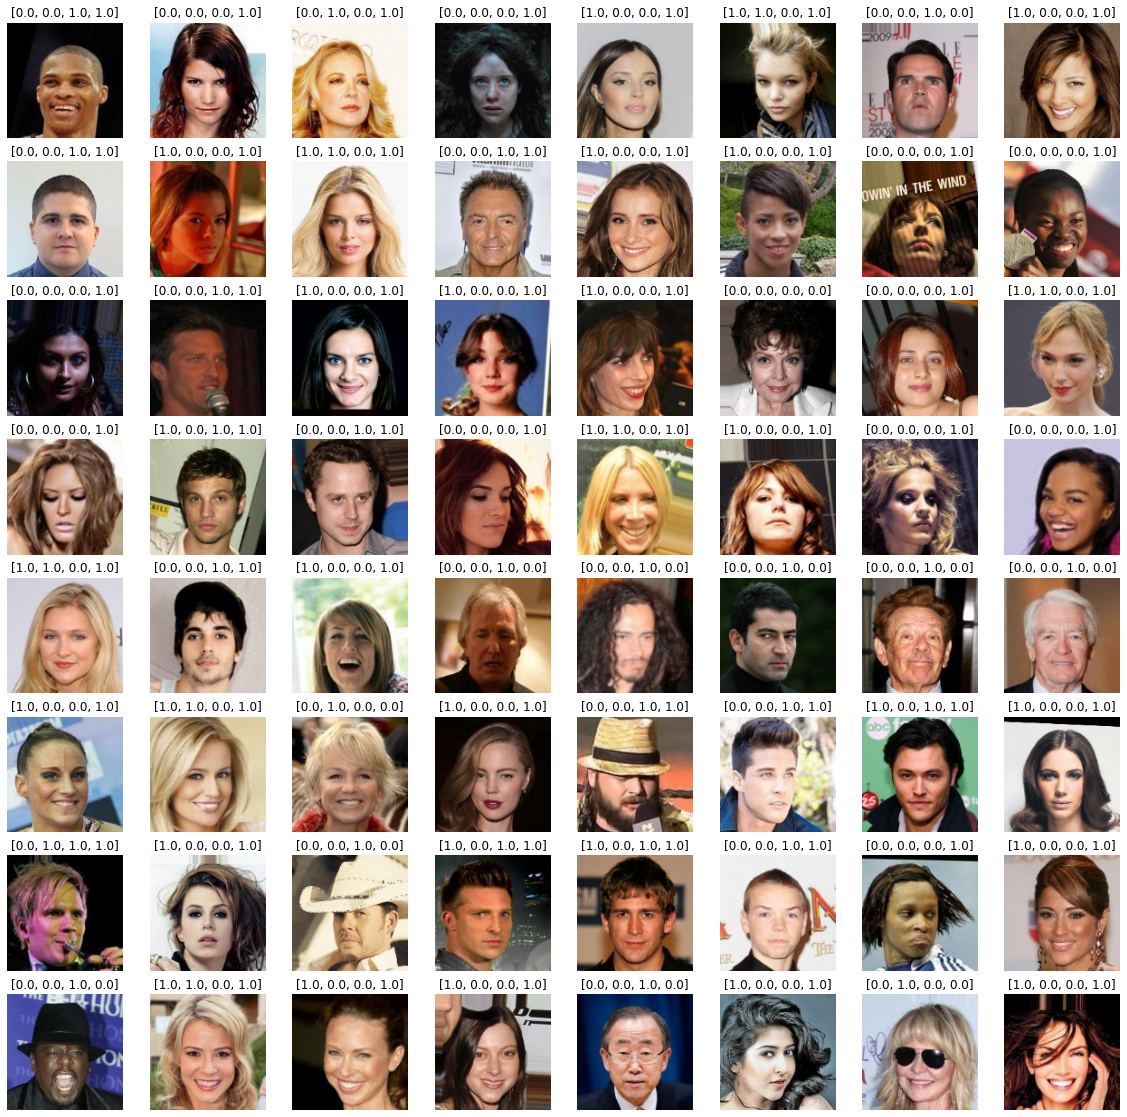

In [5]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
    img, idx = dataset[k]
    ax = fig.add_subplot(8, 8, k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax.set_title(idx.tolist())

plt.show()

# Generator

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Res_Block(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Res_Block, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True)
        )

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    def __init__(self, ngf=64, nc=4, n_res_block=6):
        super(Generator, self).__init__()
        self.n_res_block = n_res_block
        self.enc = nn.Sequential(
            # 128x128x7
            nn.Conv2d(3+nc, ngf, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(ngf, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 128x128x64
            nn.Conv2d(ngf, ngf*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 64x64x128
            nn.Conv2d(ngf*2, ngf*4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*4, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
            # 32x32x256
        )

        self.dec = nn.Sequential(
            # 32x32x256
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf*2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 64x64x128
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            # 128x128x64
            nn.Conv2d(ngf, 3, 7, 1, 3, bias=False),
            nn.Tanh()
            # 128x128x3
        )

        self.res = []
        for _ in range(n_res_block):
            block = Res_Block(ngf*4, ngf*4).to(device)
            block.apply(weights_init)
            self.res.append(block)

    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        
        x = self.enc(x)
        
        for i in range(self.n_res_block):
            x = self.res[i](x)
            
        return self.dec(x)
  
    def saveResBlocks(self, path):
        for idx, block in enumerate(self.res):
            torch.save(block.state_dict(), path.replace('.pt', F'_{idx}.pt'))

    def loadResBlocks(self, path):
        for idx in range(self.n_res_block):
            self.res[idx].load_state_dict(torch.load(path.replace('.pt', F'_{idx}.pt')))

# Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=4):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.main = nn.Sequential(
            # 128x128x3
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 64x64x64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 32x32x128
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 16x16x256
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 8x8x512
            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 4x4x1024
            nn.Conv2d(ndf*16, ndf*32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.01, inplace=True),
            # 2x2x2048
        )
        self.conv1 = nn.Conv2d(ndf*32, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf*32, nc, kernel_size=2, bias=False)

    def forward(self, x):
        x = self.main(x)        
        return self.conv1(x), self.conv2(x).view(-1, self.nc)

## Gradient Penalty

In [9]:
def calc_gradient_penalty(b_size, netD, real_data, fake_data):
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.cuda()

    interpolates = real_data + alpha * (fake_data - real_data)
    interpolates = Variable(interpolates, requires_grad=True).cuda()

    disc_interpolates, _ = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True)[0].view(interpolates.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

## Making models & Weight initialization

In [10]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [11]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv1): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2):

## (Option) Load models and lists

In [12]:
model_name = 'StarGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
fixed_path = F"{model_saved_dir}/{model_name}_fixed.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

with open(img_list_path, 'rb') as f:
    img_list = pickle.load(f)
with open(losses_path, 'rb') as f:
    G_losses, D_losses = pickle.load(f)
with open(fixed_path, 'rb') as f:
    fixed_image, fixed_label = pickle.load(f)

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))
netG.loadResBlocks(G_path)

## Optimizers

In [13]:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,beta2))

def update_lr(g_lr, d_lr):
    for param_group in optimizerG.param_groups:
        param_group['lr'] = g_lr
    for param_group in optimizerD.param_groups:
        param_group['lr'] = d_lr

## Training

In [14]:
model_name = 'StarGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
fixed_path = F"{model_saved_dir}/{model_name}_fixed.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

start_epoch = 43
continueTrain = True

if start_epoch == 0 and not continueTrain:
    img_list, G_losses, D_losses = [], [], []
    fixed_image = []
    fixed_label = []
    for i in range(5):
        img, label = dataset[i]
        for j in range(4):
            fixed_image.append(img)
            label[j] = 1.0 - label[j]
            fixed_label.append(label.clone().detach())
            label[j] = 1.0 - label[j]
    fixed_image = torch.stack(fixed_image)
    fixed_label = torch.stack(fixed_label)
    with open(fixed_path, 'wb') as f:
        pickle.dump((fixed_image, fixed_label), f)
    print("Created validation set")
    
if start_epoch >= n_ep_decay:
    now_lr = lr * (1 - (start_epoch - n_ep_decay)/(epochs - n_ep_decay))
    update_lr(now_lr, now_lr)
    print('Learning Rate decayed: %.4e' % now_lr)
    
netD.train()
netG.train()
fixed_image = fixed_image.cuda()
fixed_label = fixed_label.cuda()

for ep in range(start_epoch, epochs):
    for batch_idx, (image, label) in enumerate(dataloader, 0):
        step = ep * len(dataloader) + batch_idx + 1

        b_size = image.shape[0]
        image = Variable(image).cuda()
        target_label = label[torch.randperm(b_size)]
        label = Variable(label).cuda()
        target_label = Variable(target_label).cuda()

        # 1. Update Discriminator
        output, cls = netD(image)
        errD_real = -output.mean()
        errD_cls = F.binary_cross_entropy_with_logits(cls, label, reduction='sum') / b_size

        fake = netG(image, target_label)
        output, _ = netD(fake.detach())
        errD_fake = output.mean()

        errD_gp = calc_gradient_penalty(b_size, netD, image, fake.detach())

        errD = errD_fake + errD_real + lamb_cls * errD_cls + lamb_gp * errD_gp

        netD.zero_grad()
        netG.zero_grad()
        errD.backward()
        optimizerD.step() 
        
        # 2. Update Generator
        if step % n_critic == 0:
            fake = netG(image, target_label)
            output, cls = netD(fake)
            errG_fake = -output.mean()
            errG_cls = F.binary_cross_entropy_with_logits(cls, target_label, reduction='sum') / b_size
            
            recon = netG(fake, label)
            errG_rec = torch.mean(torch.abs(image - recon))
            
            errG = errG_fake + lamb_cls * errG_cls + lamb_rec * errG_rec

            netG.zero_grad()
            netD.zero_grad()
            errG.backward()
            optimizerG.step()

        if batch_idx % 50 == 49 or batch_idx == (len(dataloader)-1):
            print('[%3d/%3d][%4d/%4d]\tLoss_D: %.4f\tLoss_G: %.4f\n\t\t\tD(x): %.4f\tD(G(z)): %.4f / %.4f\n\t\t\tGP: %.4f\tRecon: %.4f' 
                % (ep+1, epochs, batch_idx+1, len(dataloader), errD.item(), errG.item(), 
                   -errD_real.item(), errD_fake.item(), -errG_fake.item(), errD_gp.item(), errG_rec.item()))
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
        if step % lr_update_step == 0 and ep >= n_ep_decay:
            now_lr = lr * (1 - (step - n_ep_decay*len(dataloader))/((epochs - n_ep_decay)*len(dataloader)))
            update_lr(now_lr, now_lr)
            print('Learning Rate decayed: %.4e' % now_lr)

    # Save models and lists
    with torch.no_grad():
        fake = netG(fixed_image, fixed_label).detach().cpu()
        img_list.append(fake)

    torch.save(netG.state_dict(), G_path)
    torch.save(netD.state_dict(), D_path)
    netG.saveResBlocks(G_path)

    with open(img_list_path, 'wb') as f:
        pickle.dump(img_list, f)
    with open(losses_path, 'wb') as f:
        pickle.dump((G_losses, D_losses), f)
    
    print("Saved models completely!")
    

Learning Rate decayed: 2.8000e-05
[ 44/ 50][  50/3166]	Loss_D: -1.2269	Loss_G: 0.6398
			D(x): 2.2415	D(G(z)): 0.7267 / 0.6040
			GP: 0.0086	Recon: 0.1168
[ 44/ 50][ 100/3166]	Loss_D: -1.1518	Loss_G: 0.2348
			D(x): 2.1254	D(G(z)): 0.6769 / 0.5907
			GP: 0.0074	Recon: 0.1265
[ 44/ 50][ 150/3166]	Loss_D: -1.4000	Loss_G: 0.5001
			D(x): 2.2887	D(G(z)): 0.5601 / 0.2783
			GP: 0.0103	Recon: 0.1207
[ 44/ 50][ 200/3166]	Loss_D: -0.9744	Loss_G: 0.5795
			D(x): 1.6145	D(G(z)): 0.3166 / 0.1665
			GP: 0.0080	Recon: 0.1171
[ 44/ 50][ 250/3166]	Loss_D: -1.2785	Loss_G: 0.0078
			D(x): 2.6094	D(G(z)): 0.9465 / 0.8076
			GP: 0.0084	Recon: 0.1217
[ 44/ 50][ 300/3166]	Loss_D: -1.0970	Loss_G: 0.0772
			D(x): 2.3821	D(G(z)): 0.9009 / 0.7459
			GP: 0.0087	Recon: 0.1141
[ 44/ 50][ 350/3166]	Loss_D: -1.2441	Loss_G: 0.7363
			D(x): 1.8331	D(G(z)): 0.2335 / 0.1844
			GP: 0.0087	Recon: 0.1168
[ 44/ 50][ 400/3166]	Loss_D: -1.2471	Loss_G: -0.1125
			D(x): 2.6367	D(G(z)): 1.0586 / 0.9468
			GP: 0.0110	Recon: 0.11

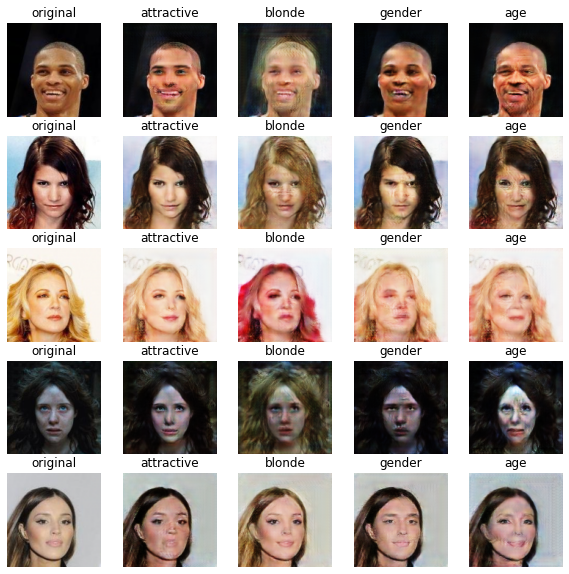

In [15]:
fig = plt.figure(figsize=(10,10))

cnt = 0
strs = ["original","attractive","blonde","gender","age"]
for k in range(25):
    ax = fig.add_subplot(5, 5, k+1)
    if k%5 == 0:
        img = fixed_image[cnt].cpu()
    else:
        img = img_list[-1][cnt]
        cnt = cnt + 1
    ax.set_title(strs[k%5])
    ax.imshow(ImgForPlot(img))
    ax.axis("off")

plt.show()

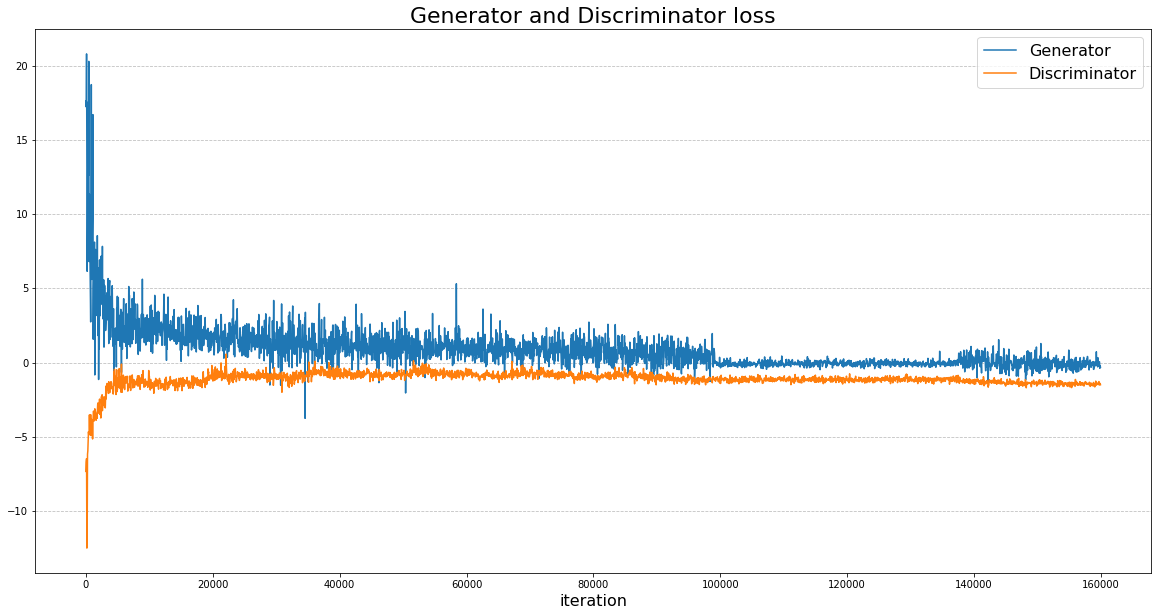

In [28]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(range(0,50*len(G_losses),50), G_losses)
plt.plot(range(0,50*len(D_losses),50), D_losses)

plt.legend(["Generator", "Discriminator"])
plt.grid(True, axis='y', color='gray', alpha=0.5, linestyle='--')
plt.title("Generator and Discriminator loss", fontsize=22)
plt.xlabel("iteration", fontsize=16)
plt.show()

## Test: Generate images

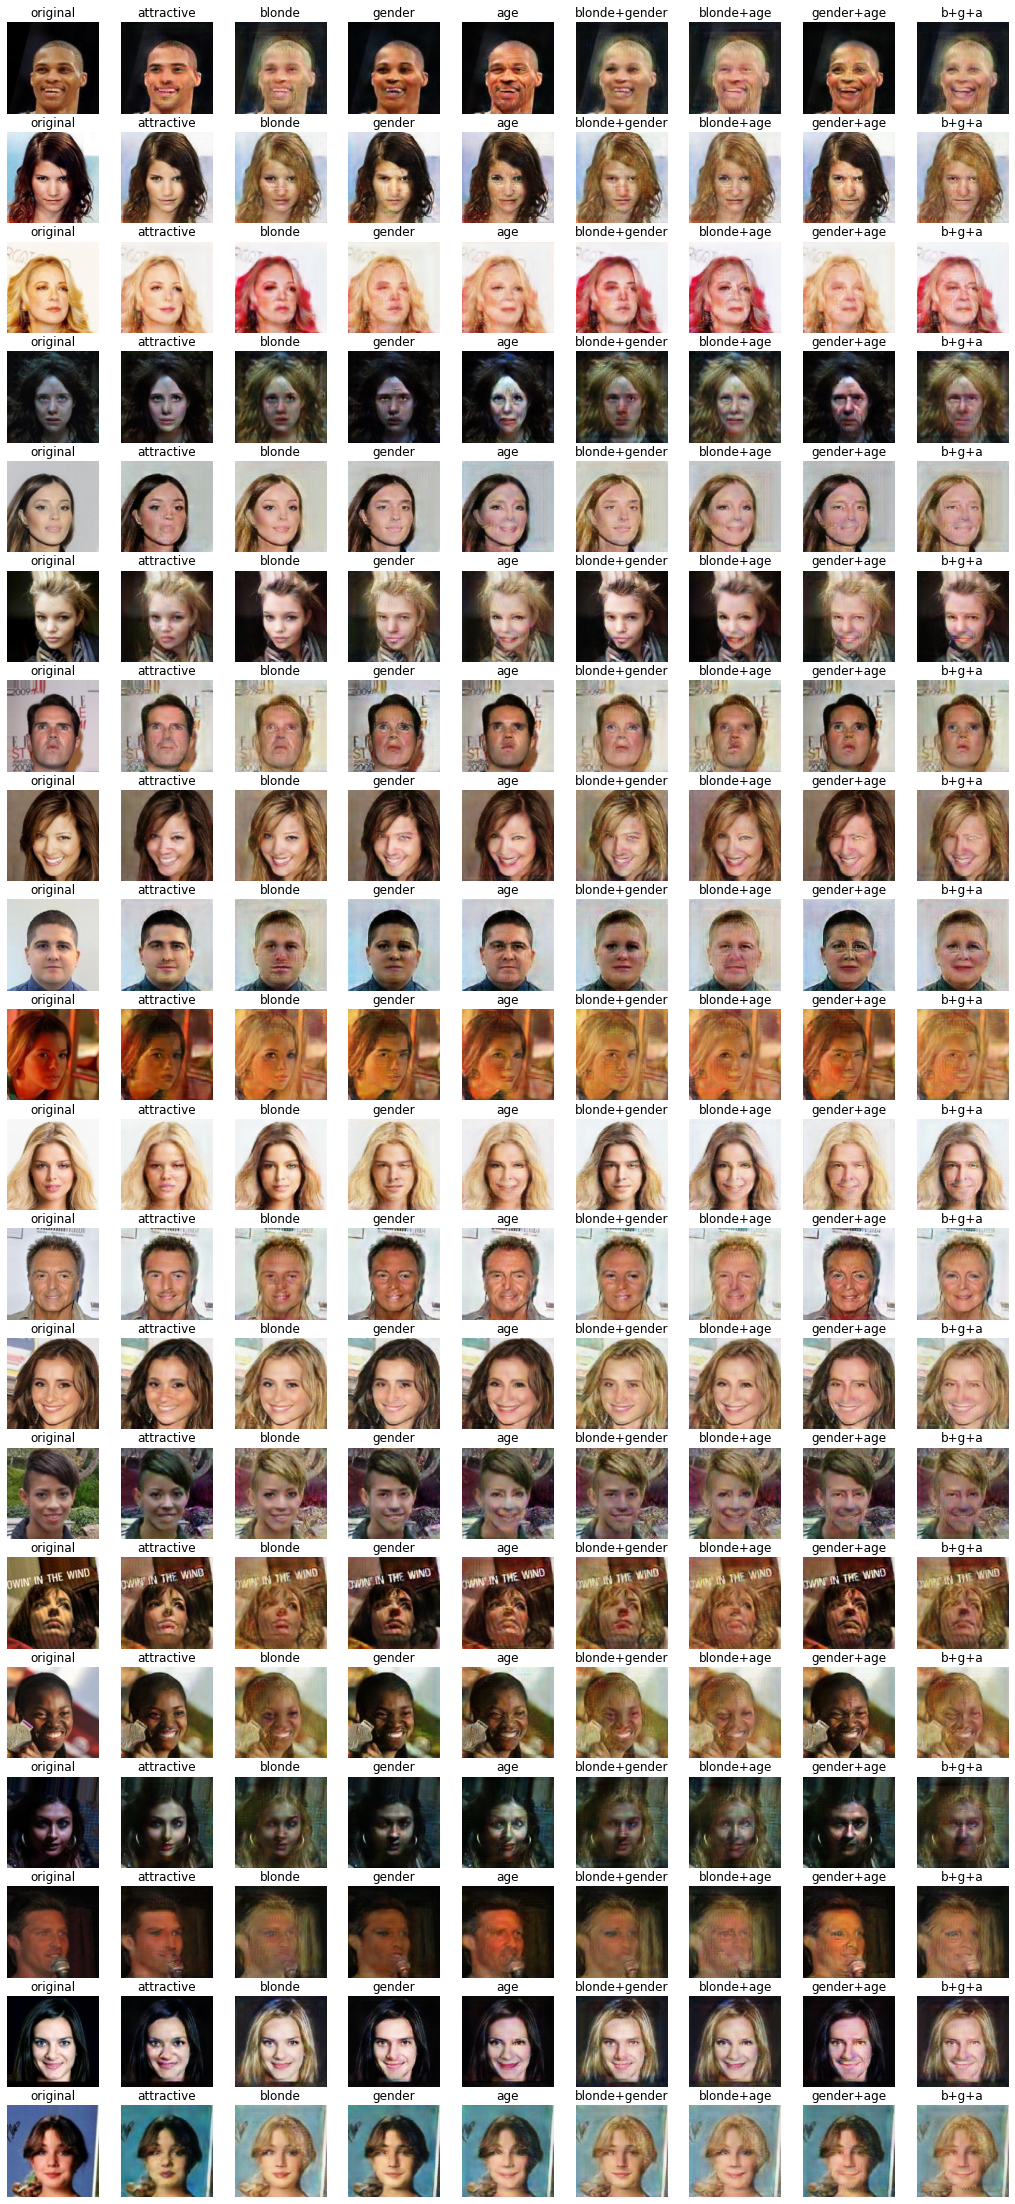

In [16]:
n_img = 20

test_image = []
test_label = []

for i in range(n_img):
    img, label = dataset[i]
    
    for j in range(8):
        test_image.append(img)
        
    for j in range(4):
        label[j] = 1.0 - label[j]
        test_label.append(label.clone().detach())
        label[j] = 1.0 - label[j]
        
    label[1] = 1.0 - label[1]
    label[2] = 1.0 - label[2]
    test_label.append(label.clone().detach()) #1,2
    label[2] = 1.0 - label[2]
    label[3] = 1.0 - label[3]
    test_label.append(label.clone().detach()) #1,3
    label[1] = 1.0 - label[1]
    label[2] = 1.0 - label[2]
    test_label.append(label.clone().detach()) #2,3
    label[1] = 1.0 - label[1]
    test_label.append(label.clone().detach()) #1,2,3
    
test_image = torch.stack(test_image).cuda()
test_label = torch.stack(test_label).cuda()

with torch.no_grad():
    output_image = netG(test_image, test_label).detach().cpu()

    
cnt = 0
strs = ["original","attractive","blonde","gender","age","blonde+gender","blonde+age","gender+age","b+g+a"]

fig = plt.figure(figsize=(2*len(strs), 2*n_img))
for k in range(n_img*len(strs)):
    ax = fig.add_subplot(n_img, len(strs), k+1)
    if k%len(strs) == 0:
        img = test_image[cnt].cpu()
    else:
        img = output_image[cnt]
        cnt = cnt + 1
    ax.set_title(strs[k%len(strs)])
    ax.imshow(ImgForPlot(img))
    ax.axis("off")

plt.show()